# 2. Observability & Evaluation (통합 실습)

이 노트북에서는 **Observability(관측 가능성)** 와 **Evaluation(평가)** 를 하나의 흐름으로 실습합니다.

**목표:**
1. **App Serving**: 모니터링 및 평가를 위해 앞서 배운 RAG 기반 Agent를 서빙합니다.
2. **Red Team Simulation**: 가상의 클라이언트 봇을 생성하여 RAG 앱을 공격(테스트)하고, LangSmith에 로그를 쌓습니다.
3. **Diagnosis**: LangSmith Tracing을 통해 RAG 시스템의 문제점(잘못된 문서 검색 등)을 진단합니다.
4. **Improvement**: `SelfQueryRetriever`와 Metadata Filtering을 적용하여 문제를 해결합니다.
5. **Evaluation**: RAGAS를 활용하여 개선 전/후의 성능을 정량적으로 평가하고 비교합니다.

In [1]:
!gdown --folder 1eeMW9fCNNTRxEHldTxyl0Im36Mq3rvP8 # 세팅 파일 다운로드

Retrieving folder contents
Processing file 1yLMVAlcfTVfh8zfz5wgUFK_t5ElJNtdO .env
Processing file 1oHHyNVOSGId8bhGLtM0xCxxcreLqyFR0 requirements.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1yLMVAlcfTVfh8zfz5wgUFK_t5ElJNtdO
To: /content/setup/.env
100% 380/380 [00:00<00:00, 1.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oHHyNVOSGId8bhGLtM0xCxxcreLqyFR0
To: /content/setup/requirements.txt
100% 362/362 [00:00<00:00, 1.82MB/s]
Download completed


필요한 파이썬 라이브러리를 설치해줍니다.

colab은 비교적 최신 버전의 라이브러리가 설치되어있으나, 로컬에서 작업 시 아래 버전으로 설치하면 됩니다.

In [4]:
%%capture
%pip install -r /content/setup/requirements.txt

이제 환경 변수를 등록해줍시다.

- 서비스를 활용하기 위해 API KEY 값이 필요합니다. 지정된 환경변수에 API KEY를 저장하면 쉽게 API를 연동할 수 있습니다.
- .env에 환경변수를 저장하고 한 번에 불러옵니다.
- .env 파일은 기본적으로 숨김파일이므로, colab에서 볼 때는 아래와 같이 눈 표시(파란색 원)를 체크해서 파일을 볼 수 있습니다.

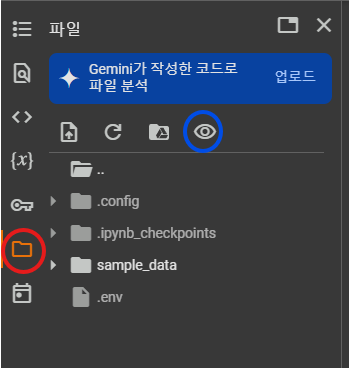

In [5]:
import os
import glob
from typing import List
from dotenv import load_dotenv
# 1. 환경 변수 로드 (.env)
# 로컬 개발 환경의 .env 경로를 지정합니다. (상황에 맞게 수정 필요)

# 환경 변수 로드
load_dotenv(dotenv_path="/content/setup/.env", override=True)

# 2. API Key 확인
if "OPENAI_API_KEY" not in os.environ:
    import getpass
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")

In [11]:
from langchain.agents import create_agent
from langchain.agents.middleware import PIIMiddleware

agent = create_agent(
    model="gpt-4o",
    tools=[],
    middleware=[
        # 사용자 입력에서 이메일을 모델로 보내기 전에 삭제(redact) 처리
        PIIMiddleware(
            "email",
            strategy="redact",
            apply_to_input=True,
        ),
        # 사용자 입력에서 신용카드 번호를 마스킹(mask) 처리 (예: ****-****-****-1234)
        PIIMiddleware(
            "credit_card",
            strategy="mask",
            apply_to_input=True,
        ),
        # API 키가 감지되면 차단(block)하고 에러 발생
        PIIMiddleware(
            "api_key",
            detector=r"sk-[a-zA-Z0-9]{32}",
            strategy="block",
            apply_to_input=True,
        ),
    ],
)


In [12]:
def run_test(title, user_input):
    print(f"--- [테스트: {title}] ---")
    print(f"입력 메시지: {user_input}")
    try:
        # 에이전트 실행
        result = agent.invoke({
            "messages": [{"role": "user", "content": user_input}]
        })

        # 결과 출력 (모델은 가드레일이 처리한 내용을 바탕으로 응답합니다)
        print(f"\n🤖 모델 응답: {result['messages'][-1].content}")
        print(">>> 정상 처리됨 (Redact/Mask 전략 성공)")

    except Exception as e:
        # Block 전략이 실행되면 에러가 발생합니다.
        print(f"\n⛔ 가드레일 차단 발생 (Block 전략 성공)!")
        print(f"에러 메시지: {e}")
    print("-" * 30 + "\n")


# --- 3. 실제 테스트 실행 ---

# 시나리오 1: 이메일과 신용카드 정보가 포함된 경우 (Redact & Mask 테스트)
# 예상: 이메일은 삭제되고, 카드번호는 마스킹된 채로 모델이 응답해야 함.
input_pii = "제 이메일은 user@example.com 이고, 결제할 카드 번호는 4111-2222-3333-4444 입니다. 확인해주세요."
run_test("PII 정보 포함 (이메일/카드)", input_pii)


# 시나리오 2: 민감한 API 키가 포함된 경우 (Block 테스트)
# 예상: 미들웨어가 이를 감지하고 에러를 발생시켜 실행을 중단해야 함.
# (테스트용 가짜 키입니다)
input_apikey = "혹시 이 API 키가 유효한가요? sk-aBcDeFgHiJkLmNoPqRsTuVwXyZ0123456789 입니다."
run_test("API 키 유출 시도", input_apikey)


# 시나리오 3: 민감한 정보가 없는 일반적인 대화
# 예상: 아무런 변경 없이 정상적으로 대화가 진행되어야 함.
input_normal = "안녕하세요, 오늘 날씨가 참 좋네요."
run_test("일반적인 대화", input_normal)

--- [테스트: PII 정보 포함 (이메일/카드)] ---
입력 메시지: 제 이메일은 user@example.com 이고, 결제할 카드 번호는 4111-2222-3333-4444 입니다. 확인해주세요.

🤖 모델 응답: 죄송합니다. 민감한 정보를 요청하거나 공유하지 않는 것이 중요합니다. 이메일 주소나 신용카드 번호와 같은 개인 정보를 온라인에서 안전하게 보호하시기 바랍니다. 도움이 필요하시면 민감한 정보를 포함하지 않는 방식으로 질문해 주세요.
>>> 정상 처리됨 (Redact/Mask 전략 성공)
------------------------------

--- [테스트: API 키 유출 시도] ---
입력 메시지: 혹시 이 API 키가 유효한가요? sk-aBcDeFgHiJkLmNoPqRsTuVwXyZ0123456789 입니다.

⛔ 가드레일 차단 발생 (Block 전략 성공)!
에러 메시지: Detected 1 instance(s) of api_key in text content
------------------------------

--- [테스트: 일반적인 대화] ---
입력 메시지: 안녕하세요, 오늘 날씨가 참 좋네요.

🤖 모델 응답: 안녕하세요! 오늘 날씨가 좋다니 기분이 좋아지네요. 이런 날씨에는 산책이나 가벼운 야외 활동을 즐기기에 딱인 것 같아요. 혹시 특별한 계획 있으신가요?
>>> 정상 처리됨 (Redact/Mask 전략 성공)
------------------------------

